In [1]:
import CMGDB

import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import os
from scipy.integrate import solve_ivp

# 4D map example

Define a map, a domain, and sample points to evaluate the map

In [2]:
def ode_func(t, state):
    """
    Compute the dynamics of the 3D LIP model
    
    Parameters:
    -----------
    t : float
        Time variable
    state : array-like
        Current state [x, y, x_dot, y_dot]
        
    Returns:
    --------
    array-like
        State derivatives [x_dot, y_dot, x_ddot, y_ddot]
    """
    x, y, x_dot, y_dot = state

    g = 9.81
    z0 = 1.0
    omega = np.sqrt(g/z0)
    
    # From equations in the paper: x'' = ω²x, y'' = ω²y
    x_ddot = omega**2 * x
    y_ddot = omega**2 * y
    
    return [x_dot, y_dot, x_ddot, y_ddot]

def reset_map(state):
    """
    Apply the discrete reset map according to the (x0, y0)-invariant gait definition
    
    Parameters:
    -----------
    state : array-like
        State before reset [x, y, x_dot, y_dot]
        
    Returns:
    --------
    array-like
        State after reset [x_new, y_new, x_dot_new, y_dot_new]
    """
    x, y, x_dot, y_dot = state
    
    # Equation (1) in the paper defines the reset map
    return [x, -y, -x_dot, y_dot]

def impact_event(r0=1.0, min_time=0.05):
    """
    Define the impact event function for the 3D LIP model
    
    Parameters:
    -----------
    r0 : float
        Radius of the impact boundary
    min_time : float, optional
        Minimum time before impact can be detected, default is 0.05s
        
    Returns:
    --------
    function
        Event function for solve_ivp
    """
    def event(t, state):
        x, y, _, _ = state
        # The switching manifold is defined as x² + y² = r0²
        dist_from_boundary = x**2 + y**2 - r0**2
        
        # Only consider impacts when crossing from inside to outside
        # and after minimum time has passed
        if t < min_time:
            return 1.0
            
        return dist_from_boundary
    
    # Terminal event (stop integration when triggered)
    event.terminal = True
    
    # Direction: +1 means detect when function goes from negative to positive
    # This means we detect when the COM moves from inside to outside the circle
    event.direction = 1
    
    return event


In [3]:
def f(x, y, x_dot, y_dot, timestep=0.4, tol=1e-6):
    current_time = 0.0
    current_state = [x,y,x_dot,y_dot]
    while current_time < timestep:
        # Determine how much time is left
        time_left = timestep - current_time
        # Simulate until next impact or until t_max
        sol = solve_ivp(
            ode_func, 
            (0, time_left), 
            current_state, 
            method='RK45', 
            events=impact_event(r0=1.0, min_time=0.05),
            dense_output=True,
            rtol=1e-8,  # Tighter tolerance
            atol=1e-10,  # Tighter tolerance
            max_step=0.1  # Limit maximum step size
        )
        # Check if we hit an impact
        impact_detected = len(sol.t_events[0]) > 0
        
        # Update current time
        current_time += sol.t[-1]
        current_state = sol.y[:, -1]

        if impact_detected:
            # Get the state at impact
            final_state = sol.y[:, -1]
            # Apply reset map
            current_state = reset_map(final_state)
    return current_state

In [4]:
dim = 4
num_pts = 50000
# r0 \in (0, 1) 
# theta \in (0, 2*pi)
# vx \in (-1, 1)
# vy \in (-1, 1)
lower_bounds = [0.0, 0, -3.0, -3.0]
upper_bounds = [1.0, 2*np.pi, 3.0, 3.0]

sample_points = np.random.uniform(lower_bounds, upper_bounds, size=(num_pts, dim))

X = np.array([[x[0]*np.cos(x[1]), x[0]*np.sin(x[1]), x[2], x[3]] for x in sample_points])

Y = np.array([f(x[0], x[1], x[2], x[3]) for x in X])

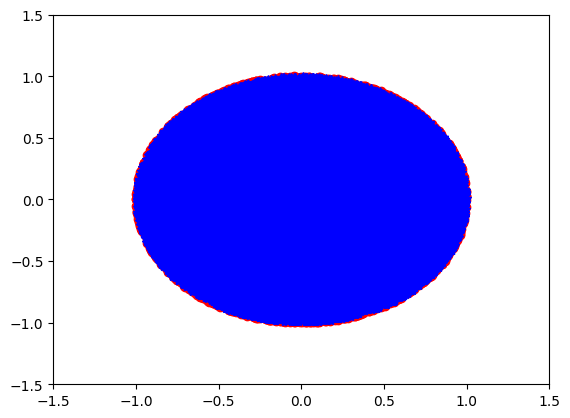

In [5]:
# Plot data
plt.plot(X[:,0], X[:,1], 'ro', Y[:,0], Y[:,1], 'b*')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

# Define a box map from data

BY default the box map interpolates empty boxes.

In [6]:
lower_bounds = [-1.0, -1.0, -3.0, -3.0]
upper_bounds = [1.0, 1.0, 3.0, 3.0]

F = CMGDB.BoxMapData(X, Y, map_empty='outside', lower_bounds=lower_bounds, upper_bounds=upper_bounds)

Use the box map above to compyte the Morse graph

In [7]:
subdiv_min = 2**4
subdiv_max = 2**4

subdiv_init = 4
subdiv_limit = 10000

model = CMGDB.Model(subdiv_min, subdiv_max, subdiv_init, subdiv_limit, lower_bounds, upper_bounds, F)

In [8]:
%%time
morse_graph, map_graph = CMGDB.ComputeMorseGraph(model)

Compute_Morse_Graph. Initializing root MorseDecomposition
Compute_Morse_Graph. A phase_space -> size () == 16
CPU times: user 10min 19s, sys: 5.91 s, total: 10min 25sCompute_Morse_Graph. B phase_space -> size () == 47051
Total Grid Memory (can be external) = 3916876
Max Memory For Single Grid (must be internal)= 1759130
Max SCC Random Access memory use (must be internal)= 341496
Max SCC stack memory use (can be external memory) = 1083208
 ---- SUMMARY ---- 
Internal Memory Requirement = 2100626
External Memory Requirement = 5000084
Max graph memory size (never stored, however) = 2109532784

Wall time: 10min 33s


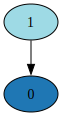

In [9]:
CMGDB.PlotMorseGraph(morse_graph)

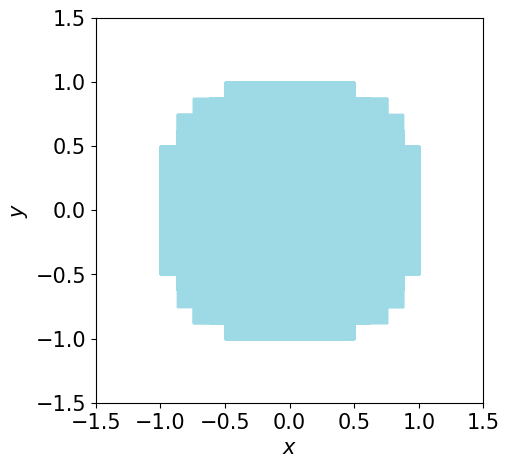

: 

In [10]:
CMGDB.PlotMorseSets(morse_graph, fig_w=5, fig_h=5,ylim=[-1.5,1.5],xlim=[-1.5,1.5])

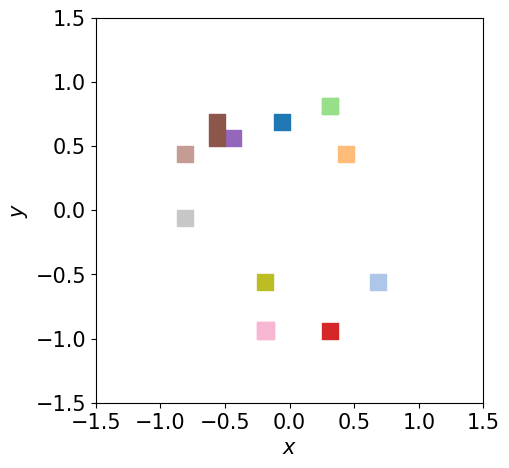

In [ ]:
CMGDB.PlotMorseSets(morse_graph, fig_w=5, fig_h=5,morse_nodes=list(range(11)),ylim=[-1.5,1.5],xlim=[-1.5,1.5])

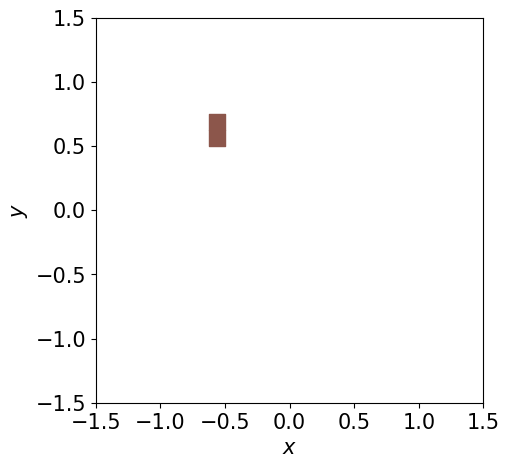

In [ ]:
CMGDB.PlotMorseSets(morse_graph, fig_w=5, fig_h=5,morse_nodes=[6],ylim=[-1.5,1.5],xlim=[-1.5,1.5])

In [ ]:
# CMGDB.PlotMorseSets(morse_graph, fig_w=5, fig_h=5,morse_nodes=[6],ylim=[-3,3],xlim=[-3,3],proj_dims=[2,3])

More refined

In [98]:
subdiv_min = 3**4
subdiv_max = 3**4

subdiv_init = 4
subdiv_limit = 10000

model = CMGDB.Model(subdiv_min, subdiv_max, subdiv_init, subdiv_limit, lower_bounds, upper_bounds, F)


In [ ]:
%%time
morse_graph, map_graph = CMGDB.ComputeMorseGraph(model)

Compute_Morse_Graph. Initializing root MorseDecomposition
Compute_Morse_Graph. A phase_space -> size () == 16
CPU times: user 35.4 s, sys: 1.05 s, total: 36.5 sCompute_Morse_Graph. B phase_space -> size () == 10627

Wall time: 39.8 s
Total Grid Memory (can be external) = 12323584
Max Memory For Single Grid (must be internal)= 887342
Max SCC Random Access memory use (must be internal)= 123097
Max SCC stack memory use (can be external memory) = 347248
 ---- SUMMARY ---- 
Internal Memory Requirement = 1010439
External Memory Requirement = 12670832
Max graph memory size (never stored, however) = 148174520


In [ ]:
CMGDB.PlotMorseGraph(morse_graph)

In [101]:
CMGDB.PlotMorseSets(morse_graph, fig_w=5, fig_h=5,ylim=[-1.5,1.5],xlim=[-1.5,1.5])

IndexError: list index out of range

In [ ]:
CMGDB.PlotMorseSets(morse_graph, fig_w=5, fig_h=5,morse_nodes=[0,1,2],ylim=[-1.5,1.5],xlim=[-1.5,1.5])

In [ ]:
CMGDB.PlotMorseSets(morse_graph, fig_w=5, fig_h=5,morse_nodes=[0,1,2],ylim=[-1.5,1.5],xlim=[-1.5,1.5],proj_dims=[2,3])